# МОДЕЛИРОВАНИЕ СИСТЕМЫ ХРАНЕНИЯ ДАННЫХ

## ОПИСАНИЕ

## СОДЕРЖАНИЕ

## РЕЗЮМЕ

## КОНФИГУРАЦИЯ

### ИМПОРТ БИБЛИОТЕК

In [136]:
# import pymc3 as pm
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import itertools
import re
import glob
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ARDRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale, StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

In [137]:
folder_path = 'Correct sizes'  # Path of raw data

### DOCUMENTATION

Фиксируем возможные значения параметров, описываем их тип.

In [138]:
doc = {'protection': ['2REP', '3REP', 'EC2.1'],  #cat. # maybe more types later
       'size': [8, 128, 1e3, 128e3],  # cont.
       'nodes': np.linspace(4, 16, 13, dtype = int),  # cont.
       'type': ['write', 'read'],  # cat.
       'HW_chassis': ['X205', 'VEGMAN'],  # cat.
       'SSD': [2, 4]  # cont.
      }

cat_params = ['protection', 'type', 'HW_chassis']
cont_params = ['size', 'nodes', 'SSD']

all_options = np.array(list(itertools.product( *(doc[key] for key in list(doc.keys())) )))

all_options_w_ops = np.concatenate((all_options, [[0] for _ in range(len(all_options))]), axis = 1)


**Установим общий вид .txt / .md файла замера**

```
protection=<protecrion_value>
HW_chassis=<hardware_chassis_value>
SSD=<number_of_ssd>

### <number_of_nodes> nodes <object's_size> <type> // begin of size
INFO[<time>] Load started at: <date> (<timezone>) source=<source_value> 
INFO[<time>] Load finished at: <date> (<timezone>)source=<source_value>   
█ setup

\``` // _begin of block with size results from one installation_
 █ teardown

 aws_obj_put_bytes......: <float> <unit_of_measurement>  <float><unit_of_measurement>/s
 
 aws_obj_put_duration...: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 aws_obj_put_success....: <float> <float>/s
 data_received..........: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 data_sent..............: <float> <unit_of_measurement> <float> <unit_of_measurement>/s
 iteration_duration.....: avg=<float><unit_of_measurement> min=<float><unit_of_measurement> med=<float><unit_of_measurement> max=<float><unit_of_measurement> p(90)=<float><unit_of_measurement>  p(95)=<float><unit_of_measurement>
 iterations.............: <float> <float>/s
 vus....................: <float> min=<float> max=<float>
\``` // _end of block with size results from one installation_
// there can be several blocks for one size
```

## ИССЛЕДУЕМЫЕ ДАННЫЕ

### READER

Скрипт читает все файлы замеров и переводит замеры в словарь ```Data```, в котором ключи --- параметры железа.

Структура ```Data```: $$\left\{\begin{pmatrix}protection \\ size \\ nodes \\ w/r \\ HW\_chassis \\ SSD \end{pmatrix}:\;\begin{Bmatrix}MB/s: & list \\ avg: & list\\ min: & list \\ med: & list \\ max: & list \\ p(90): & list \\ p(95): & list \\ op/s: & list \\ op/s\_loss: & list \\ SUM\_MB/s: & float \\ SUM\_op/s: & float\end{Bmatrix}\right\}$$

In [139]:
txt_files = glob.glob(f"{folder_path}/*.txt")
md_files = glob.glob(f"{folder_path}/*.md")

all_files = txt_files + md_files


Data = dict()

for file_path in all_files:
    with open(file_path, 'r', encoding='utf-8') as file:
        
        ###
        lines = file.readlines()
        data = []
        for line in lines:
            data.append( line.strip().split(' ') )


        file_protection = [temp_data[0].split('=')[1].upper() for temp_data in data if 'protection' in temp_data[0]][0]
 
        file_HW_chassis = [temp_data[0].split('=')[1].upper() for temp_data in data if 'HW_chassis' in temp_data[0]][0]

        file_SSD = [int(temp_data[0].split('=')[1]) for temp_data in data if 'SSD' in temp_data[0]][0]
  
        i = 0
        counter = 0
        print(str(data).count('###'),f'correct number of sizes {file_path}')
        # realization of data reading functions
        while i < len(data):
            
            if '###' in data[i]:
                counter += 1
                Params = dict.fromkeys(list(doc.keys()))
                for temp in list( Params.keys() ):
                    Params[temp] = 0
                
                temp_data_0 = [k for k in data[i] if len(k) > 0]
                
                Params['protection'] = file_protection
                Params['SSD'] = file_SSD
                Params['nodes'] = int(temp_data_0[1])
                Params['type'] =  temp_data_0[4].lower()
                Params['HW_chassis'] = file_HW_chassis
                
                if re.fullmatch( r'(\b\d*kb\b)', str( temp_data_0[3] ).lower()):  # size like kb
                    Params['size'] = float(temp_data_0[3][:-2])
                elif re.fullmatch( r'(\b\d*kib\b)', str( temp_data_0[3] ).lower() ):  #size like kib
                    Params['size'] = float(temp_data_0[3][:-3])
                elif re.fullmatch( r'(\b\d*mb\b)', str( temp_data_0[3] ).lower() ):  #size like mb
                    Params['size'] = float(temp_data_0[3][:-2]) * 1000  # convert to KB
                elif re.fullmatch( r'(\b\d*mib\b)', str( temp_data_0[3] ).lower() ):  #size like mib
                    Params['size'] = float(temp_data_0[3][:-3]) * 1000
                else:
                    Params['size'] = 'INCORRECT DATA'
                
                i += 1
                
                Input = dict.fromkeys(['MB/s', 'avg', 'min', 'med', 'max', 'p(90)', 'p(95)','op/s','op/s_loss', 'SUM_MB/s','SUM_op/s'])
                for temp in list( Input.keys() ):
                    Input[temp] = []
                '''
                op/s_loss --- perfomance fails
                SUM_MB/s, SUM_op/s --- SUM of perfomance in MB/s, op/s
                '''

                while i < len(data) - 1 and not('###' in data[i+1]):
                    
                    if 'aws_obj_get_bytes' in str(data[i]) or 'aws_obj_put_bytes' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        if str(temp_data[-1]).lower() == 'mb/s':
                            Input['MB/s'].append(float(temp_data[-2]))
                        elif str(temp_data[-1]).lower() == 'gb/s':
                            Input['MB/s'].append(float(temp_data[-2]) * 1000)  # convert to mb/s
                        else:
                            Input['MB/s'].append('INCORRECT DATA')
                    
                    if 'aws_obj_get_duration' in str(data[i]) or 'aws_obj_put_duration' in str(data[i]):
                        temp_data = [k.split('=') for k in data[i] if len(k) > 0]
                        for j in range(1,6+1):                            
                            if 'ms' in str(temp_data[j][1]).lower():  # case M.SECONDS
                                Input[temp_data[j][0]].append(float(temp_data[j][1][:-2]))  # we suppose that notation <digits>m<digits><MS> is impossible 
                                    
                            else:  # case SECONDS 
                                match = re.fullmatch( r'(\b\d*\dm\d\d*\w*\b)', str(temp_data[j][1]).lower() )  # <digits (at least 1)>m<digits (at least 1)><s> - found m in d[b][1] in seconds
                                if match:
                                    Input[temp_data[j][0]].append((float(str(temp_data[j][1][:-1]).split('m')[0]) * 60 + float(str(temp_data[j][1][:-1]).split('m')[1])) * 1000)  # convert to ms| found m
                                else:
                                    Input[temp_data[j][0]].append(float(temp_data[j][1][:-1]) * 1000)  # convert to ms
            
                    if 'aws_obj_put_success' in str(data[i]) or 'aws_obj_get_success' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s'].append(float(temp_data[2][:-2:]))  #obj/s
                        
            
                    if 'aws_obj_get_fails' in str(data[i]):
                        temp_data = [k for k in data[i] if len(k) > 0]
                        Input['op/s_loss'].append(float(temp_data[2][:-2:]))  #obj/s
                    i += 1
                ### found '###' or end of file, update our Data                    
                
                # realization of agregate functions 
                Input['SUM_MB/s'] = np.sum(Input['MB/s'])
                Input['SUM_op/s'] = np.sum(Input['op/s'])
                
                ###
                
                Data[tuple(Params.values())] = Input
            i += 1
                        
    print(counter, f'get number of sizes {file_path}')


39 correct number of sizes Correct sizes\Sizer results for rep3.txt
39 get number of sizes Correct sizes\Sizer results for rep3.txt
61 correct number of sizes Correct sizes\Sizer_results_1.txt
61 get number of sizes Correct sizes\Sizer_results_1.txt
40 correct number of sizes Correct sizes\sizer_results_8nodes_rep2 (2).md
40 get number of sizes Correct sizes\sizer_results_8nodes_rep2 (2).md
56 correct number of sizes Correct sizes\sizer_results_ec2.1_retest_actual.md
56 get number of sizes Correct sizes\sizer_results_ec2.1_retest_actual.md


### CONVERTER

Конвертирует словарь ```Data``` в список ```Data_list```.

In [140]:
Data_list = []
for key in list(Data.keys()):
    Data_list.append(list(key) + list(Data[key].values()) )
Header = list(Params.keys())
for key in list(Data.keys()):
    Header += list(Data[key].keys())
    break

### WRITER

Записывает ```Data_list``` в .xlsx файл.

In [141]:
df = pd.DataFrame(Data_list, columns = Header)
df.to_excel('output.xlsx', index=False, header=True)

### ONE HOT ENCODER MODULE

Переводит строковые категориальные признаки в унитарные.

In [142]:
def features_transformation(Data: dict, doc = doc) -> pd.DataFrame:  # CHECK CODE AFTER EVERY UPDATE!
    X = np.array([list(key) + [Data[key]['SUM_op/s']] for key in list(Data.keys())])
    Y = all_options_w_ops # massive of all posible key values, target values = 0
    X = np.vstack((X, Y))
    header = list(doc.keys()); header.append('SUM_op/s')
    X_OHE_DF = pd.get_dummies(pd.DataFrame(X, columns = header), columns = cat_params, prefix = cat_params)  # cat params
    X_OHE_DF['size'] = X_OHE_DF['size'].astype(float)
    X_OHE_DF['nodes'] = X_OHE_DF['nodes'].astype(int)
    X_OHE_DF['SUM_op/s'] = X_OHE_DF['SUM_op/s'].astype(float)
    X_OHE_DF['SSD'] = X_OHE_DF['SSD'].astype(int)
    X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
    return (X_OHE_DF.drop(['protection_2REP', 'type_read', 'HW_chassis_VEGMAN'], axis=1, inplace=False)).head(len(Data))  # drop collinear columns - CAN CHANGES

In [143]:
print(features_transformation(Data))  # debug

         size  nodes  SSD      SUM_op/s  protection_3REP  protection_EC2.1  \
0         8.0     16    2   9680.554701                1                 0   
1         8.0     16    2  20065.334488                1                 0   
2       128.0     16    2   5681.330100                1                 0   
3       128.0     16    2  18788.737276                1                 0   
4      1000.0     16    2   2042.689679                1                 0   
..        ...    ...  ...           ...              ...               ...   
189     128.0      4    2   1936.546119                0                 1   
190    1000.0      4    2    646.974487                0                 1   
191    1000.0      4    2    797.192718                0                 1   
192  128000.0      4    2      7.994045                0                 1   
193  128000.0      4    2     11.903917                0                 1   

     type_write  HW_chassis_X205  
0             1             

C:\Users\shiri\AppData\Local\Temp\ipykernel_17132\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


## АНАЛИЗ

### RAW DATA

Посмотрим, как ведёт себя целевое значение на имеющихся данных вдоль выбранного параметра при фиксированных прочих.

In [144]:
def compare (key: tuple, parametr: str, fix_params: dict) -> bool:
    i = 0
    while str(parametr) != str(list(fix_params.keys())[i]):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    i += 1
    while i < len(list(fix_params.keys())):
        if str(key[i]) != str(list(fix_params.values())[i]):
            return 0
            break
        i += 1
    return 1

def key_enum (param: str, doc = doc):
    i = 0
    while i < len(list(doc.keys())):
        if str(param) == str(list(doc.keys())[i]):
            return i
            break
        i += 1
    return 'ERROR'

In [145]:
params = list(doc.keys())
print(f'remember, that there is some params we must to fix: \n{params}\nimportant: now we`re working with raw data - what we put, that we get\n\ncontinious parametrs:\n{cont_params}\n\ncategorial parametrs:\n{cat_params}')

remember, that there is some params we must to fix: 
['protection', 'size', 'nodes', 'type', 'HW_chassis', 'SSD']
important: now we`re working with raw data - what we put, that we get

continious parametrs:
['size', 'nodes', 'SSD']

categorial parametrs:
['protection', 'type', 'HW_chassis']


In [146]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching (order as in documentation dictionary - it`s important)
fix_params = {
    'protection': '3REP',
    'size': 1e3,
    'nodes': 15,
    'type': 'read',
    'HW_chassis': 'X205',
    'SSD': 2
}
### we can define here other pack of params for compare
fix_params_2 = {
    'protection': '3REP',
    'size': 1e3,
    'nodes': 15,
    'type': 'write',
    'HW_chassis': 'X205',
    'SSD': 2
}
###

params:
           first graph second graph
protection        3REP         3REP
size            1000.0       1000.0
type              read        write
HW_chassis        X205         X205
SSD                  2            2


Text(0, 0.5, 'Op per sec')

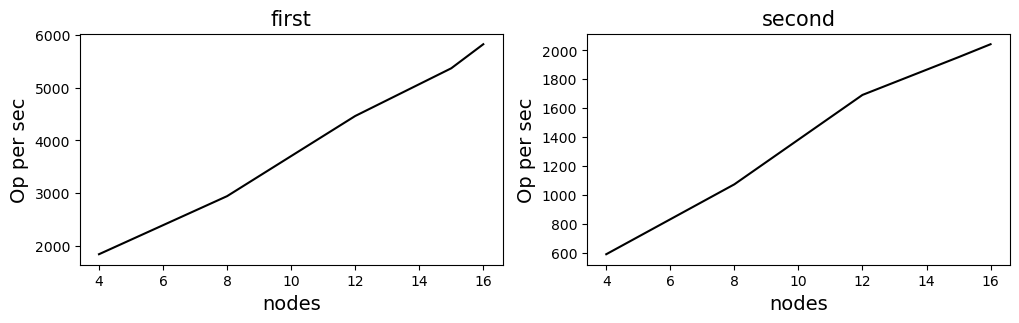

In [147]:
Z = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ]
)).T

W = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params_2)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params_2)
    ]
)).T

plt.figure(figsize=(12, 3)) 

plt.subplot(1, 2, 1)
plt.xscale('linear')

Z = Z[Z[:, 0].argsort()].T; W = W[W[:, 0].argsort()].T

graph_title = {key: {'first graph': fix_params[key], 'second graph': fix_params_2[key]} for key in list(doc.keys())}

plt.plot(Z[0], Z[1],'k-', alpha = 1)
graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.title('first', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')


plt.subplot(1, 2, 2)
plt.xscale('linear')
plt.plot(W[0], W[1],'k-', alpha = 1)
plt.title('second', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')




### МОДЕЛИРОВАНИЕ

_about_: В планах: использовать байесовские методы из PyMC. На данный момент реализация со sklearn.

#### Преобразование данных 

In [156]:

def size_transformation(X: np.ndarray) -> np.ndarray:
    #mu_size = np.concatenate((np.linspace(1, 1e3, 7), [128e3]))
    mu_size = [8, 128, 1e3, 128e3]
    sigma_size = 2e2
    #sigma_size = [10, 10, 1e1, 1e1]
    X = X.T
    return np.concatenate([
        [
            np.exp(-(X - mu_size[i]) ** 2 / sigma_size ** 2) for i in range(0, 4)
        ] + # size' gaussians
        [
            X ** i for i in range(0, 2)
        ] + # size' poly
        [
            np.exp(-X ** i) for i in range(1, 3)
        ]
    ]).T

def nodes_transformation(X: np.ndarray) -> np.ndarray:
    X.T
    return np.concatenate([
        [
            np.log(X) ** k for k in range(1, 2)
        ] + # nodes' log
        [
            X ** k for k in range(0, 2)
        ] # nodes' poly
    ]).T

def nodes_cross_size_transformation(nodes: np.ndarray, size: np.ndarray) -> np.ndarray:
    nodes.T; size.T
    cross = []
    for x, y in zip(nodes, size):
        z = []
        z.append(1)
        for i in x:
            for j in y:
                z.append( i * j )
        cross.append(z)
    return np.array(cross)




def phi(Data: dict) -> (np.ndarray, np.ndarray):
    raw_features = features_transformation(Data)
    categorial = np.array(raw_features.drop(columns=['size', 'nodes', 'SUM_op/s']))
    target = np.array(raw_features['SUM_op/s'])
    features = np.concatenate(
        (
            nodes_cross_size_transformation(
                nodes_transformation(np.array(raw_features['nodes'])),
                size_transformation(np.array(raw_features['size']))
            ),
            #size_transformation(np.array(raw_features['size'])),
            #nodes_transformation(np.array(raw_features['nodes'])),
            categorial
        ), axis = 1
    )
    return (features, target)



#### Обучение модели

In [166]:

X = phi(Data)[0]  # predictors 
Y = phi(Data)[1]  # target
X_x_Y = np.column_stack([X,Y])
X_x_Y_bootstrap = []
for i in np.random.choice(np.linspace(0, len(X_x_Y)-1, len(X_x_Y), dtype = int), size = int(1e5)):
    X_x_Y_bootstrap.append( X_x_Y[i] )
X_x_Y_bootstrap = np.array(X_x_Y_bootstrap)

#X_x_Y_bootstrap = X_x_Y

X_train_LR, X_test_LR, Y_train_LR, Y_test_LR = train_test_split(
    X_x_Y_bootstrap[:, :-1], 
    X_x_Y_bootstrap[:, -1], 
    test_size = .6, 
    random_state = 28
)
'''
generate train set from our Data
'''
sc = StandardScaler()
sc.fit(X_train_LR[:, :-4])
X_train_LR = np.concatenate(
    (sc.transform(X_train_LR[:, :-4]), X_train_LR[:, -4:]), axis = 1
)
X_test_LR = np.concatenate(
    (sc.transform(X_test_LR[:, :-4]), X_test_LR[:, -4:]), axis = 1
)
M = LinearRegression(fit_intercept = False)
M.fit(X_train_LR, Y_train_LR) 
print('Weight matrix:',M.coef_)
n = len(list(Data.keys()))
k = len(list(Data.keys())[0])

### Linear Regression
LR_train_MSE = round(mean_squared_error(Y_train_LR, M.predict(X_train_LR)), 3)
LR_train_R2_adj = round(1 - (1- r2_score(Y_train_LR, M.predict(X_train_LR)) ) * (n - 1) / (n - k - 1), 3)
LR_test_MSE = round(mean_squared_error(Y_test_LR, M.predict(X_test_LR)), 3)
LR_test_R2_adj = round(1 - (1- r2_score(Y_test_LR, M.predict(X_test_LR)) ) * (n - 1) / (n - k - 1), 3)
###


LR_results = pd.DataFrame(['Linear regression', LR_train_MSE, LR_train_R2_adj, LR_test_MSE, LR_test_R2_adj]).transpose()
LR_results.columns = ['Method', 'Training MSE', 'Training R2_ad', 'Test MSE', 'Test R2_ad']
print('**Metrics**: \n', LR_results)

C:\Users\shiri\AppData\Local\Temp\ipykernel_17132\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_17132\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)


Weight matrix: [ 1.82313007e+09  5.13985489e+14 -3.64291003e+14  1.02532357e+13
  1.17598173e+15 -6.38056697e+11 -1.17143361e+15  9.12628477e+14
 -1.16593376e+15  6.56097486e+14  5.33315547e+14  9.65984871e+14
 -8.30665079e+14  1.08803441e+15  1.82018995e+15  4.16608563e+14
 -4.53852297e+14 -9.52299219e+15  8.05786811e+15  1.12250636e+15
 -4.12847570e+15 -1.04707684e+15  5.31146162e+15  4.27448748e+15
  6.03167950e+14  3.21056250e+03 -7.01679688e+01 -2.49049023e+03
 -3.00258789e+03  7.35981250e+03]
**Metrics**: 
               Method Training MSE Training R2_ad     Test MSE Test R2_ad
0  Linear regression  4219570.415          0.795  4219650.355      0.795


#### Графики предсказанной даты

In [172]:
parametr = 'nodes'
'''
It's an Ox' value
(Oy always is a target value --- perfomance)
'''

### fix other params for detail searching (order as in documentation dictionary - it`s important)
fix_params = {
    'protection': '3REP',
    'size': 1e3,
    'nodes': 15,
    'type': 'read',
    'HW_chassis': 'X205',
    'SSD': 2
}
### we can define here other pack of params for compare
fix_params_2 = {
    'protection': '2REP',
    'size': 1e3,
    'nodes': 15,
    'type': 'read',
    'HW_chassis': 'X205',
    'SSD': 2
}
###

C:\Users\shiri\AppData\Local\Temp\ipykernel_17132\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_17132\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_OHE_DF = X_OHE_DF.replace({True: 1, False: 0}).infer_objects(copy=False)
C:\Users\shiri\AppData\Local\Temp\ipykernel_17132\4015556992.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a fu

Z_p= [[4.000e+00 3.071e+03]
 [5.000e+00 3.227e+03]
 [6.000e+00 3.413e+03]
 [7.000e+00 3.622e+03]
 [8.000e+00 3.846e+03]
 [9.000e+00 4.082e+03]
 [1.000e+01 4.327e+03]
 [1.100e+01 4.577e+03]
 [1.200e+01 4.837e+03]
 [1.300e+01 5.101e+03]
 [1.400e+01 5.371e+03]
 [1.500e+01 5.643e+03]
 [1.600e+01 5.918e+03]]
params:
           first set second set
protection      3REP       2REP
size          1000.0     1000.0
type            read       read
HW_chassis      X205       X205
SSD                2          2


Text(0, 0.5, 'Op per sec')

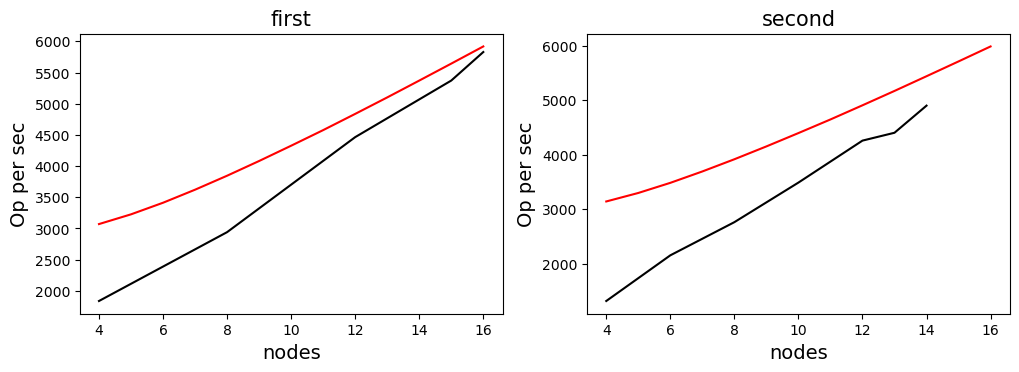

In [173]:
Z = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params)
    ]
)).T

W = np.array((
    [
        key[key_enum(parametr)] for key in list(Data.keys()) if compare(key, parametr, fix_params_2)
    ],
    [
        Data[key]['SUM_op/s'] for key in list(Data.keys()) if compare(key, parametr, fix_params_2)
    ]
)).T


### from old realization 1st set
target_params = [ fix_params.copy() for _ in range(len(doc[parametr])) ]
for i in range(len(doc[parametr])):
    target_params[i][parametr] = doc[parametr][i]
target_keys = [ tuple(x.values()) for x in target_params ]
target_values = [ Data[key]['SUM_op/s'] for key in target_keys if key in list(Data.keys())]
Data_t = {key: {'SUM_op/s': 0} for key in target_keys}
###

### from old realization 2nd set
target_params_2 = [ fix_params_2.copy() for _ in range(len(doc[parametr])) ]
for i in range(len(doc[parametr])):
    target_params_2[i][parametr] = doc[parametr][i]
target_keys_2 = [ tuple(x.values()) for x in target_params_2 ]
target_values_2 = [ Data[key]['SUM_op/s'] for key in target_keys_2 if key in list(Data.keys())]
Data_t_2 = {key: {'SUM_op/s': 0} for key in target_keys_2}
###

Z_p = np.array((
    [ x[parametr] for x in target_params],
    M.predict(np.concatenate(
    (sc.transform(phi(Data_t)[0][:, :-4]), phi(Data_t)[0][:, -4:]), axis = 1
    ))
)).T

W_p = np.array((
    [ x[parametr] for x in target_params_2],
    M.predict(np.concatenate(
    (sc.transform(phi(Data_t_2)[0][:, :-4]), phi(Data_t_2)[0][:, -4:]), axis = 1
    ))
)).T

print('Z_p=', Z_p)

plt.figure(figsize=(12, 8)) 

# ITERPOLATION

plt.subplot(2, 2, 1)
plt.xscale('linear')

Z = Z[Z[:, 0].argsort()].T; W = W[W[:, 0].argsort()].T
Z_p = Z_p[Z_p[:, 0].argsort()].T; W_p = W_p[W_p[:, 0].argsort()].T

graph_title = {key: {'first set': fix_params[key], 'second set': fix_params_2[key]} for key in list(doc.keys())}

plt.plot(Z[0], Z[1],'k-', alpha = 1)  # raw
plt.plot(Z_p[0], Z_p[1],'r-', alpha = 1)  # predicted

graph_title.pop(parametr, None)
print(f'params:\n{pd.DataFrame(graph_title).transpose()}')
plt.title('first', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')

plt.subplot(2, 2, 2)
plt.xscale('linear')
plt.plot(W[0], W[1],'k-', alpha = 1)  # raw
plt.plot(W_p[0], W_p[1],'r-', alpha = 1)  # predicted

plt.title('second', fontsize=15)
plt.xlabel(parametr, fontsize=14, color='k')
plt.ylabel('Op per sec', fontsize=14, color='k')




## ИТОГИ